# Lecture 9 Workbook
## Two way ANOVA
This is a workbook that contains the python code that was used in slides
appearing in the lecture. It is provided so that you can see for yourself
how this code works.

## Definitions and setup
Code here is just for making everything look sort of *uniform*

In [1]:
%matplotlib inline
from itertools import islice
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import pandas as pd
from IPython.display import HTML

course_data = 'https://github.com/opherdonchin/StatisticalComputationAndAnalysis/raw/main/Data/'

In [2]:
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

This is the seed for the random number generator. Graphs for the course will be generated with seed 367 (for BME). You can change it or use 'shuffle' to get different pseudo-random numbers each time.

In [3]:
np.random.seed(367)

## Load data
Load data on cerebellar volumes

In [4]:
height_data = pd.read_csv(os.path.join(course_data, 'age_height.csv'))




## Multiple factors in ANOVA

### Heights of males and females, children and adults (as a one way ANOVA)

C:\Users\Opher\AppData\Local\Temp\ipykernel_21660\2152422283.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='height', data=height_data,


Text(0, 0.5, 'Height')

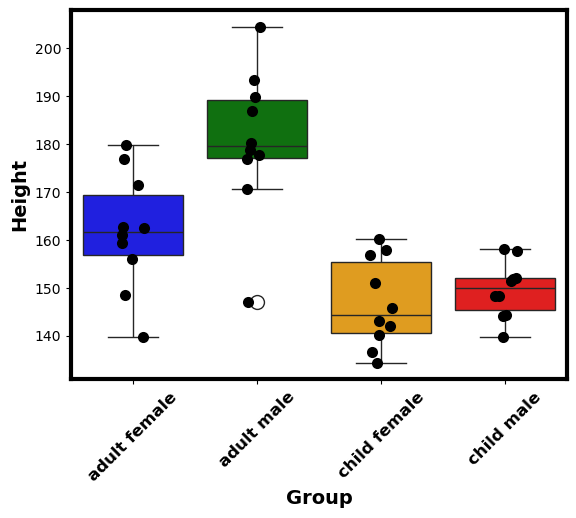

In [5]:
# Create a multi-index column using sex and age
height_data['group'] = height_data['age'] + ' ' + height_data['sex']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the boxplot using seaborn boxplot
sns.boxplot(x='group', y='height', data=height_data,
            palette={"adult female": "blue", "adult male": "green",
                     "child female": "orange", "child male": "red"}, ax=ax)

# Plot the data points using seaborn stripplot
sns.stripplot(x='group', y='height', dodge=False, data=height_data,
              color='black',
              size=8, ax=ax)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, fontweight='bold', fontsize=12)

# Set the x-axis and y-axis labels
ax.set_xlabel('Group')
ax.set_ylabel('Height')

### Do one way ANOVA

In [6]:
# Convert DataFrame column to numpy array
y = height_data['height'].to_numpy()

# Create dummy variables based on the group column
dummy_group = pd.get_dummies(height_data['age'] + '_' + height_data['sex'], prefix='D', drop_first=True)

# Combine the dummy variables
X = pd.concat([dummy_group], axis=1)
X = np.hstack((np.ones((X.shape[0], 1)), X))

b = np.linalg.pinv(X.T @ X) @ X.T @ y
yHat = X @ b
r = y - yHat
s2YX = np.sum(r**2)

SSRes = np.sum(r**2)
dfRes = X.shape[0] - X.shape[1]
s2YX = SSRes / dfRes
SSReg = np.sum((yHat - np.mean(y))**2)
dfReg = X.shape[1] - 1
SSTot = np.sum((y - np.mean(y))**2)

MSres = SSRes / dfRes
MSreg = SSReg / dfReg

R2 = SSReg / SSTot
Cohenf = np.sqrt(SSReg / SSRes)
F = MSreg / MSres
p_value_F = 1 - stats.f.cdf(F, dfReg, dfRes)

Text(0.2, 0.2, "$SSRes=4534.57$\n$dfRes=36$\n$MSRes=125.96$\n$SSReg=7112.22$\n$dfReg=3$\n$MSReg=2370.74$\n$SSTot=11646.79$\n$s^2_y = 125.960332$\n$R^2 = 0.61$\nCohen's $f = 1.25$\n$F(3, 36) = 18.82$\n$p = 1.6403e-07$")

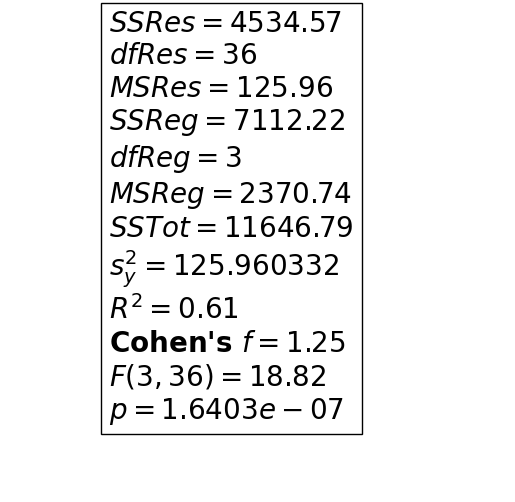

In [7]:
plt.axis('off')
plt.text(0.2, 0.2,
          f"${SSRes=:.2f}$\n${dfRes=}$\n$MSRes={SSRes/dfRes:.2f}$\n${SSReg=:.2f}$\n${dfReg=}$\n$MSReg={SSReg/dfReg:.2f}$\n${SSTot=:.2f}$\n"
          f"$s^2_y = {s2YX:2f}$\n"
          f"$R^2 = {R2:.2f}$\nCohen's $f = {Cohenf:.2f}$\n"
          f"$F({dfReg}, {dfRes}) = {F:.2f}$\n$p = {p_value_F:.5g}$",
         fontsize=20, fontweight='bold', bbox=dict(boxstyle='square', facecolor='white'))

#### Statistics for coefficients

In [8]:
b_D = b[1:]
d = b_D / np.sqrt(s2YX)

bvar = s2YX * np.linalg.inv(X.T @ X)
seb = np.sqrt(np.diag(bvar))
seb_D = seb[1:]

t_value = b_D / seb_D
p_value_t = 1 - stats.t.cdf(np.abs(t_value), dfRes)

t_results_df = pd.DataFrame({'b': b_D, 'd': d, 't_value': t_value, 'p_value': p_value_t}, index=dummy_group.columns)

t_results_df


,b,d,t_value,p_value
D_adult_male,18.812225,1.676190,3.748075,0.000312
D_child_female,-15.036228,-1.339745,-2.995760,0.002466
D_child_male,-12.206671,-1.087628,-2.432010,0.010059


#### Statistics for comparing two coefficients

Text(0.2, 0.2, '$b_3 - b_1 = -31.02$\n$d_{3,1} = -2.76$\n$se_{b_{3,1}} = 5.02$\n$t_{3,1} = -6.18$\n$p_{3,1} = 1.998e-07$\n')

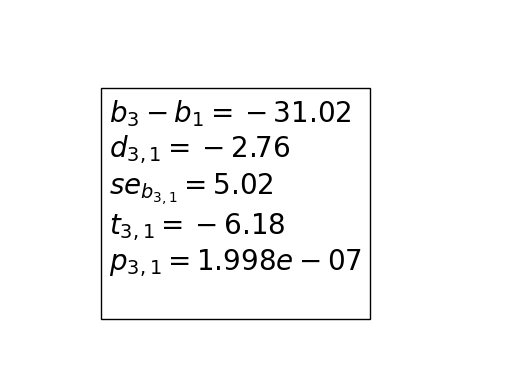

In [9]:
b31 = b[3] - b[1]
d31 = b31 / np.sqrt(s2YX)

se_b31 = np.sqrt(bvar[3, 3] + bvar[1, 1] - 2 * bvar[3, 1])
t31 = b31 / se_b31
p31 = 1 - stats.t.cdf(np.abs(t31), dfRes)

plt.axis('off')
plt.text(0.2, 0.2,
          f"$b_3 - b_1 = {b31:.2f}$\n"
          f"$d_{{3,1}} = {d31:.2f}$\n"
          f"$se_{{b_{{3,1}}}} = {se_b31:.2f}$\n"
          f"$t_{{3,1}} = {t31:.2f}$\n"
          f"$p_{{3,1}} = {p31:.5g}$\n",
         fontsize=20, fontweight='bold', bbox=dict(boxstyle='square', facecolor='white'))

## Adding interactions

### Two way ANOVA without interaction

In [10]:
# Create dummy variables based on age and sex columns
dummy_age = pd.get_dummies(height_data['age'], prefix='D', drop_first=True)
dummy_sex = pd.get_dummies(height_data['sex'], prefix='D', drop_first=True)

# Combine the dummy variables
X = pd.concat([dummy_age, dummy_sex], axis=1)
X = np.hstack((np.ones((X.shape[0], 1)), X))

b = np.linalg.pinv(X.T @ X) @ X.T @ y
yHat = X @ b
r = y - yHat
s2YX = np.sum(r**2)

SSRes = np.sum(r**2)
dfRes = X.shape[0] - X.shape[1]
s2YX = SSRes / dfRes
SSReg = np.sum((yHat - np.mean(y))**2)
dfReg = X.shape[1] - 1
SSTot = np.sum((y - np.mean(y))**2)

MSres = SSRes / dfRes
MSreg = SSReg / dfReg

R2 = SSReg / SSTot
Cohenf = np.sqrt(SSReg / SSRes)
F = MSreg / MSres
p_value_F = 1 - stats.f.cdf(F, dfReg, dfRes)

In [11]:
yHat_CM = b[0]+b[1]+b[2]
yBar_CM = height_data.loc[(height_data['group'] == 'child male'), 'height'].mean()

Text(0.2, 0.2, '$b_A = -23.03$\n$b_S = 10.82$\n$\\hat{y}_{CM} = 153.61$\n$\\overline{y}_{CM} = 149.62$\n')

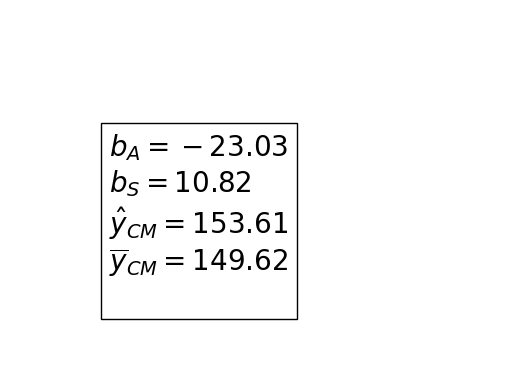

In [12]:
plt.axis('off')
plt.text(0.2, 0.2,
          f"$b_A = {b[1]:.2f}$\n"
          f"$b_S = {b[2]:.2f}$\n"
          f"$\hat{{y}}_{{CM}} = {yHat_CM:.2f}$\n"
          f"$\overline{{y}}_{{CM}} = {yBar_CM:.2f}$\n",
         fontsize=20, fontweight='bold', bbox=dict(boxstyle='square', facecolor='white'))

### Add an interaction term

In [13]:
import numpy as np
import pandas as pd
from scipy import stats

# Create dummy variables based on age and sex columns
dummy_age = pd.get_dummies(height_data['age'], prefix='D', drop_first=True)
dummy_sex = pd.get_dummies(height_data['sex'], prefix='D', drop_first=True)

# Create the interaction term between age and sex
dummy_age_sex = dummy_age['D_child'].multiply(dummy_sex['D_male'])

# Combine the dummy variables and interaction term
X = pd.concat([dummy_age, dummy_sex, dummy_age_sex], axis=1)
X = np.hstack((np.ones((X.shape[0], 1)), X))

b = np.linalg.pinv(X.T @ X) @ X.T @ y
yHat = X @ b
r = y - yHat
s2YX = np.sum(r**2)

SSRes = np.sum(r**2)
dfRes = X.shape[0] - X.shape[1]
s2YX = SSRes / dfRes
SSReg = np.sum((yHat - np.mean(y))**2)
dfReg = X.shape[1] - 1
SSTot = np.sum((y - np.mean(y))**2)

MSres = SSRes / dfRes
MSreg = SSReg / dfReg

R2 = SSReg / SSTot
Cohenf = np.sqrt(SSReg / SSRes)
F = MSreg / MSres
p_value_F = 1 - stats.f.cdf(F, dfReg, dfRes)


Text(0.2, 0.2, "$SSRes=4534.57$\n$dfRes=36$\n$MSRes=125.96$\n$SSReg=7112.22$\n$dfReg=3$\n$MSReg=2370.74$\n$SSTot=11646.79$\n$s^2_y = 125.960332$\n$R^2 = 0.61$\nCohen's $f = 1.25$\n$F(3, 36) = 18.82$\n$p = 1.6403e-07$")

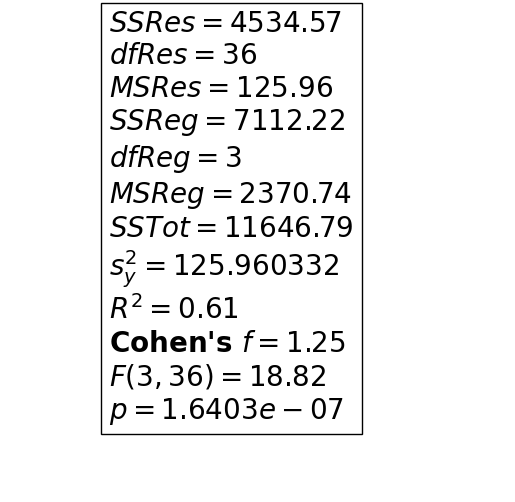

In [14]:
plt.axis('off')
plt.text(0.2, 0.2,
          f"${SSRes=:.2f}$\n${dfRes=}$\n$MSRes={SSRes/dfRes:.2f}$\n${SSReg=:.2f}$\n${dfReg=}$\n$MSReg={SSReg/dfReg:.2f}$\n${SSTot=:.2f}$\n"
          f"$s^2_y = {s2YX:2f}$\n"
          f"$R^2 = {R2:.2f}$\nCohen's $f = {Cohenf:.2f}$\n"
          f"$F({dfReg}, {dfRes}) = {F:.2f}$\n$p = {p_value_F:.5g}$",
         fontsize=20, fontweight='bold', bbox=dict(boxstyle='square', facecolor='white'))

In [15]:
b_D = b[1:]
d = b_D / np.sqrt(s2YX)

bvar = s2YX * np.linalg.inv(X.T @ X)
seb = np.sqrt(np.diag(bvar))
seb_D = seb[1:]

t_value = b_D / seb_D
p_value_t = 1 - stats.t.cdf(np.abs(t_value), dfRes)

t_results_df = pd.DataFrame({'b': b_D, 'd': d, 't_value': t_value, 'p_value': p_value_t}, index=['Age', 'Male', 'Age_Male'])

t_results_df

,b,d,t_value,p_value
Age,-15.036228,-1.339745,-2.995760,0.002466
Male,18.812225,1.676190,3.748075,0.000312
Age_Male,-15.982668,-1.424073,-2.251658,0.015270


Text(0.2, 0.2, '$b_A = -15.04$\n$b_M = 18.81$\n$b_AM = -15.98$\n')

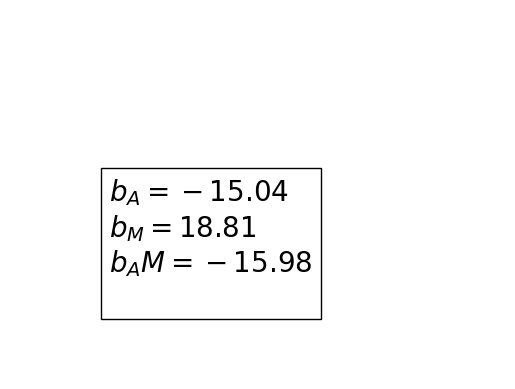

In [16]:
plt.axis('off')
plt.text(0.2, 0.2,
          f"$b_A = {b[1]:.2f}$\n"
          f"$b_M = {b[2]:.2f}$\n"
          f"$b_AM = {b[3]:.2f}$\n",
         fontsize=20, fontweight='bold', bbox=dict(boxstyle='square', facecolor='white'))